In [ ]:
from sklearn.datasets import fetch_lfw_people
import PIL
import numpy as np
import os
import zipfile
from google.colab import files
from io import BytesIO
import torch
import requests
from diffusers import RePaintPipeline, RePaintScheduler
from PIL import Image, ImageOps

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=14, resize=1, color=True)

print(len(lfw_people.target_names))

first_100_people = np.unique(lfw_people.target)[:100]

person_images = []

os.makedirs('/content/lfw_100_people', exist_ok=True)

for person_id in first_100_people:
    first_idx = np.where(lfw_people.target == person_id)[0][0]
    image_array = lfw_people.images[first_idx]
    person_name = lfw_people.target_names[person_id]

    img = Image.fromarray((image_array * 255).astype(np.uint8))

    img = img.resize((256, 256))

    # Clean filename (remove special characters)
    clean_name = "".join(c if c.isalnum() or c in (' ', '-', '_') else '_' for c in person_name)
    filename = f"{clean_name}_{person_id}.jpg"
    filepath = f"/content/lfw_100_people/{filename}"

    img.save(filepath)
    person_images.append((filename, person_name, person_id))

with zipfile.ZipFile('/content/lfw_100_people.zip', 'w') as zipf:
    for root, dirs, file_list_from_walk in os.walk('/content/lfw_100_people'):
        for file_name in file_list_from_walk:
            filepath = os.path.join(root, file_name)
            zipf.write(filepath, os.path.basename(filepath))

files.download('/content/lfw_100_people.zip')
print(f"Downloaded {len(person_images)} images with celebrities' name")

106


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded 100 images with celebrities' name


In [ ]:
img.size

(256, 256)

In [ ]:
zip_file_path = '/content/100masks80corruption.zip'
extraction_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"'{zip_file_path}' unzipped to '{extraction_path}'")

extracted_folder_name = '100masks80corruption'
full_path = os.path.join('/content/', extracted_folder_name)

print(f"Contents of '{full_path}':")
if os.path.exists(full_path) and os.path.isdir(full_path):
    for item in os.listdir(full_path):
        print(item)
else:
    print(f"Folder '{full_path}' not found.")


mask_folder = '/content/100masks80corruption'

if os.path.exists(mask_folder) and os.path.isdir(mask_folder):
    all_files = os.listdir(mask_folder)

    # Filter for mask files (assuming they end with .png)
    mask_files = [f for f in all_files if f.startswith('mask_') and f.endswith('.png')]

    # Sort the files numerically based on the number in the filename
    mask_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    if mask_files:
        print(f"First mask filename: {mask_files[0]}")
        print(f"Last mask filename: {mask_files[-1]}")
    else:
        print(f"No mask files found in {mask_folder}.")
else:
    print(f"Folder '{mask_folder}' not found or is not a directory.")

'/content/100masks80corruption.zip' unzipped to '/content/'
Contents of '/content/100masks80corruption':
mask_89.png
mask_24.png
mask_47.png
mask_53.png
mask_8.png
mask_0.png
mask_82.png
mask_31.png
mask_4.png
mask_96.png
mask_94.png
mask_40.png
mask_69.png
mask_85.png
mask_32.png
mask_79.png
mask_45.png
mask_21.png
mask_99.png
mask_90.png
mask_61.png
mask_5.png
mask_44.png
mask_36.png
mask_16.png
mask_80.png
mask_13.png
mask_97.png
mask_95.png
mask_68.png
mask_81.png
mask_63.png
mask_14.png
mask_26.png
mask_7.png
mask_10.png
mask_76.png
mask_60.png
mask_54.png
mask_98.png
mask_86.png
mask_25.png
mask_23.png
mask_38.png
mask_22.png
mask_15.png
mask_83.png
mask_2.png
mask_33.png
mask_17.png
mask_34.png
mask_28.png
mask_51.png
mask_39.png
mask_78.png
mask_29.png
mask_20.png
mask_84.png
mask_75.png
mask_56.png
mask_9.png
mask_27.png
mask_46.png
mask_77.png
mask_64.png
mask_57.png
mask_74.png
mask_18.png
mask_62.png
mask_67.png
mask_65.png
mask_91.png
mask_93.png
mask_72.png
mask_70.png
ma

In [ ]:
len(mask_files)

100

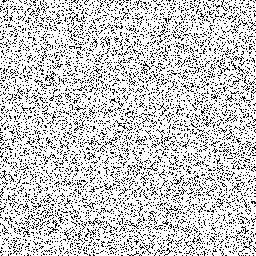

In [ ]:
from PIL import Image
image_mask80 = Image.open("/content/mask_00000.png")

crop_box = (0, 0, 94, 125)

cropped_mask = image_mask80.crop(crop_box)

image_mask80

In [ ]:
import os
import numpy as np
from PIL import Image
from multiprocessing import Pool, cpu_count
import math
from tqdm.notebook import tqdm
import psutil
import shutil

def generate_batch(args):
    percent, output_folder, batch_start, batch_size, size, num_pixels_to_mask = args
    total_pixels = size * size

    for i in range(batch_size):
        mask_id = batch_start + i
        mask = np.zeros((size, size), dtype=np.uint8)

        indices = np.random.choice(total_pixels, num_pixels_to_mask, replace=False)
        mask.flat[indices] = 255

        filename = f"mask_{mask_id:05d}.png"
        filepath = os.path.join(output_folder, filename)

        img = Image.fromarray(mask)
        img.save(filepath)

    return batch_start, batch_size

def generate_masks_colab(output_root="masks", size=256, num_masks=30000, num_workers=None, batch_size=500):
    if num_workers is None:
        num_workers = max(1, min(4, cpu_count() // 2))

    levels = {
        20: "20",
        40: "40",
        60: "60",
        80: "80"
    }
    os.makedirs(output_root, exist_ok=True)

    print(f"🔧 Colab Configuration:")
    print(f"   - CPU cores available: {cpu_count()}")
    print(f"   - Using {num_workers} workers")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Total masks per level: {num_masks}")
    print(f"   - Mask size: {size}x{size}\n")

    for percent, folder in levels.items():
        folder_path = os.path.join(output_root, folder)
        os.makedirs(folder_path, exist_ok=True)

        num_pixels_to_mask = int((percent / 100) * size * size)

        print(f"🎯 Generating {num_masks} masks with {percent}% coverage...")
        print(f"   - Pixels to mask: {num_pixels_to_mask} per mask")
        print(f"   - Output folder: {folder_path}")

        num_batches = math.ceil(num_masks / batch_size)

        # Prepare batch arguments
        args_list = []
        for batch_idx in range(num_batches):
            batch_start = batch_idx * batch_size
            current_batch_size = min(batch_size, num_masks - batch_start)
            args_list.append((percent, folder_path, batch_start, current_batch_size, size, num_pixels_to_mask))

        # Process batches in parallel with notebook progress bar
        with Pool(processes=num_workers) as pool:
            results = []
            for result in tqdm(pool.imap_unordered(generate_batch, args_list),
                             total=num_batches,
                             desc=f"{percent}% masks",
                             unit="batch"):
                results.append(result)

        generated_files = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
        print(f"✅ {percent}% masks completed: {generated_files}/{num_masks} files")

        # Memory cleanup
        import gc
        gc.collect()

    print(f"\n🎉 All mask generation complete!")
    print(f"📁 Masks saved in: {output_root}/")

def check_colab_environment():
    try:
        import google.colab
        in_colab = True
        print("🚀 Running in Google Colab Jupyter Notebook")

        print(f"💻 CPU: {cpu_count()} cores")
        memory_gb = psutil.virtual_memory().total / (1024**3)
        print(f"💾 RAM: {memory_gb:.1f} GB available")

        try:
            import torch
            if torch.cuda.is_available():
                gpu_name = torch.cuda.get_device_name(0)
                gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
                print(f"🎮 GPU: {gpu_name} ({gpu_memory:.1f} GB)")
            else:
                print("🎮 GPU: Not available")
        except ImportError:
            print("🎮 GPU: PyTorch not available for GPU check")

        return True
    except ImportError:
        print("🔧 Running in local Jupyter environment")
        return False

def run_mask_generation():
    """Main function to run mask generation in Colab notebook"""

    is_colab = check_colab_environment()

    if is_colab:
        # Conservative settings for Colab to avoid crashes
        config = {
            'output_root': "masks",
            'size': 256,
            'num_masks': 30000,
            'num_workers': 4,  # Conservative for Colab stability
            'batch_size': 250  # Smaller batches to manage memory
        }
    else:
        # More aggressive settings for local machines
        config = {
            'output_root': "masks",
            'size': 256,
            'num_masks': 30000,
            'num_workers': 8,
            'batch_size': 500
        }

    print(f"\n⚙️ Starting mask generation with configuration:")
    for key, value in config.items():
        print(f"   {key}: {value}")

    generate_masks_colab(**config)

    print(f"\n📊 Final verification:")
    total_masks = 0
    for percent in [20, 40, 60, 80]:
        folder_path = os.path.join(config['output_root'], str(percent))
        if os.path.exists(folder_path):
            count = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
            total_masks += count
            print(f"   {percent}%: {count} masks")

    expected_total = config['num_masks'] * 4
    print(f"   Total: {total_masks}/{expected_total} masks generated")

    if total_masks == expected_total:
        print("🎉 All masks generated successfully!")
    else:
        print("⚠️ Some masks may be missing - check output folders")

    return total_masks


def mount_google_drive():
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted at /content/drive")

    drive_masks_path = "/content/drive/MyDrive/masks_dataset"
    os.makedirs(drive_masks_path, exist_ok=True)
    print(f"Masks can be saved to: {drive_masks_path}")
    return drive_masks_path

def quick_test():
    print("🧪 Running quick test with 100 masks per level...")
    test_config = {
        'output_root': "test_masks",
        'size': 256,
        'num_masks': 100,  # Small number for testing
        'num_workers': 2,
        'batch_size': 50
    }
    generate_masks_colab(**test_config)
    print("✅ Quick test completed!")

    test_folder = "test_masks/20"
    if os.path.exists(test_folder):
        files = sorted(os.listdir(test_folder))[:5]
        print(f"Sample files: {files}")

def zip_masks(output_root="masks"):
    import zipfile
    import shutil

    zip_path = f"{output_root}_dataset.zip"

    print(f"📦 Creating zip archive: {zip_path}")
    shutil.make_archive(output_root, 'zip', output_root)

    file_size = os.path.getsize(zip_path) / (1024**3)
    print(f"📁 Zip file created: {zip_path} ({file_size:.2f} GB)")

    return zip_path

def display_folder_structure():
    print("📁 Generated folder structure:")
    for root, dirs, files in os.walk("masks"):
        level = root.replace("masks", "").count(os.sep)
        indent = " " * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = " " * 2 * (level + 1)
        if level == 1:
            print(f"{sub_indent}... {len(files)} mask files")

In [ ]:
check_colab_environment()

🚀 Running in Google Colab Jupyter Notebook
💻 CPU: 2 cores
💾 RAM: 12.7 GB available
🎮 GPU: Not available


True

In [ ]:
!rm -rf /content/test_masks
# quick_test()

drive_path = mount_google_drive()
generate_masks_colab(output_root=drive_path, num_masks=30000, num_workers=4, batch_size=250)

# zip_path = zip_masks()

display_folder_structure()

Mounted at /content/drive
Google Drive mounted at /content/drive
Masks can be saved to: /content/drive/MyDrive/masks_dataset
🔧 Colab Configuration:
   - CPU cores available: 2
   - Using 4 workers
   - Batch size: 250
   - Total masks per level: 30000
   - Mask size: 256x256

🎯 Generating 30000 masks with 20% coverage...
   - Pixels to mask: 13107 per mask
   - Output folder: /content/drive/MyDrive/masks_dataset/20


20% masks:   0%|          | 0/120 [00:00<?, ?batch/s]

✅ 20% masks completed: 30000/30000 files
🎯 Generating 30000 masks with 40% coverage...
   - Pixels to mask: 26214 per mask
   - Output folder: /content/drive/MyDrive/masks_dataset/40


40% masks:   0%|          | 0/120 [00:00<?, ?batch/s]

✅ 40% masks completed: 30000/30000 files
🎯 Generating 30000 masks with 60% coverage...
   - Pixels to mask: 39321 per mask
   - Output folder: /content/drive/MyDrive/masks_dataset/60


60% masks:   0%|          | 0/120 [00:00<?, ?batch/s]

✅ 60% masks completed: 30000/30000 files
🎯 Generating 30000 masks with 80% coverage...
   - Pixels to mask: 52428 per mask
   - Output folder: /content/drive/MyDrive/masks_dataset/80


80% masks:   0%|          | 0/120 [00:00<?, ?batch/s]

✅ 80% masks completed: 30000/30000 files

🎉 All mask generation complete!
📁 Masks saved in: /content/drive/MyDrive/masks_dataset/
📁 Generated folder structure:


In [ ]:
def check_drive_status():
    local_base = "masks"
    drive_base = "/content/drive/MyDrive/masks_dataset"

    print("Drive Status:")
    for percent in ["20", "40", "60", "80"]:
        local_folder = os.path.join(local_base, percent)
        drive_folder = os.path.join(drive_base, percent)

        local_count = len(os.listdir(local_folder)) if os.path.exists(local_folder) else 0
        drive_count = len(os.listdir(drive_folder)) if os.path.exists(drive_folder) else 0

        status = "✅ Synced" if local_count == drive_count else "⚠️ Out of sync"
        print(f"  {percent}%: Local={local_count}, Drive={drive_count} - {status}")

# Check before syncing
check_drive_status()

Drive Status:
  20%: Local=0, Drive=0 - ✅ Synced
  40%: Local=0, Drive=0 - ✅ Synced
  60%: Local=0, Drive=0 - ✅ Synced
  80%: Local=0, Drive=0 - ✅ Synced


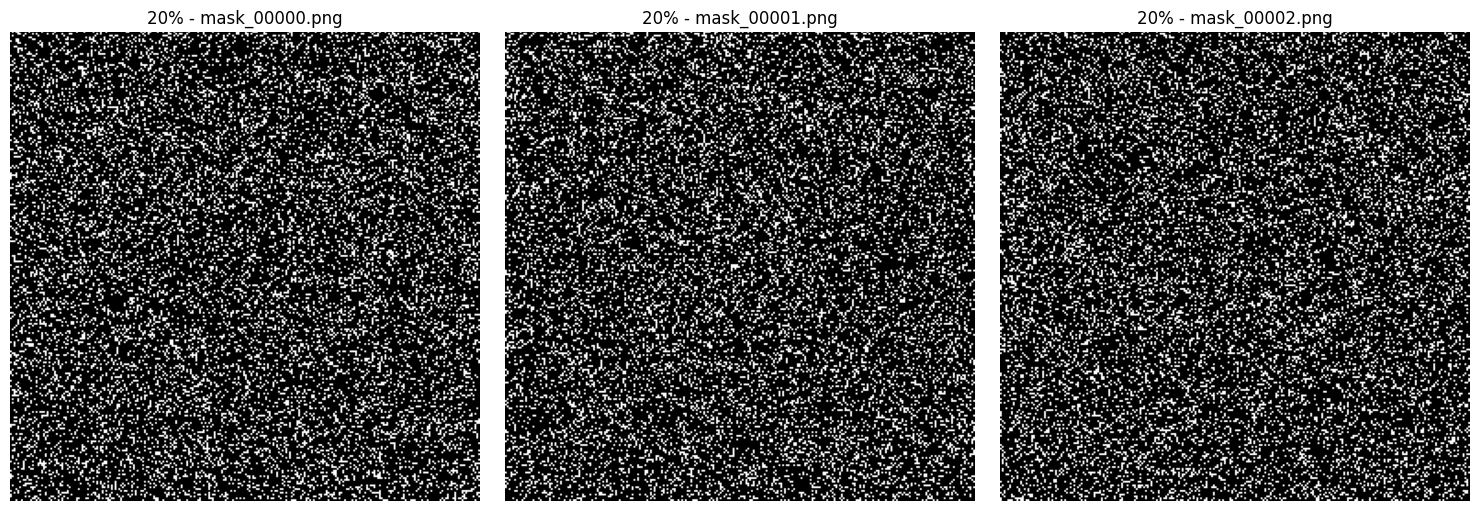

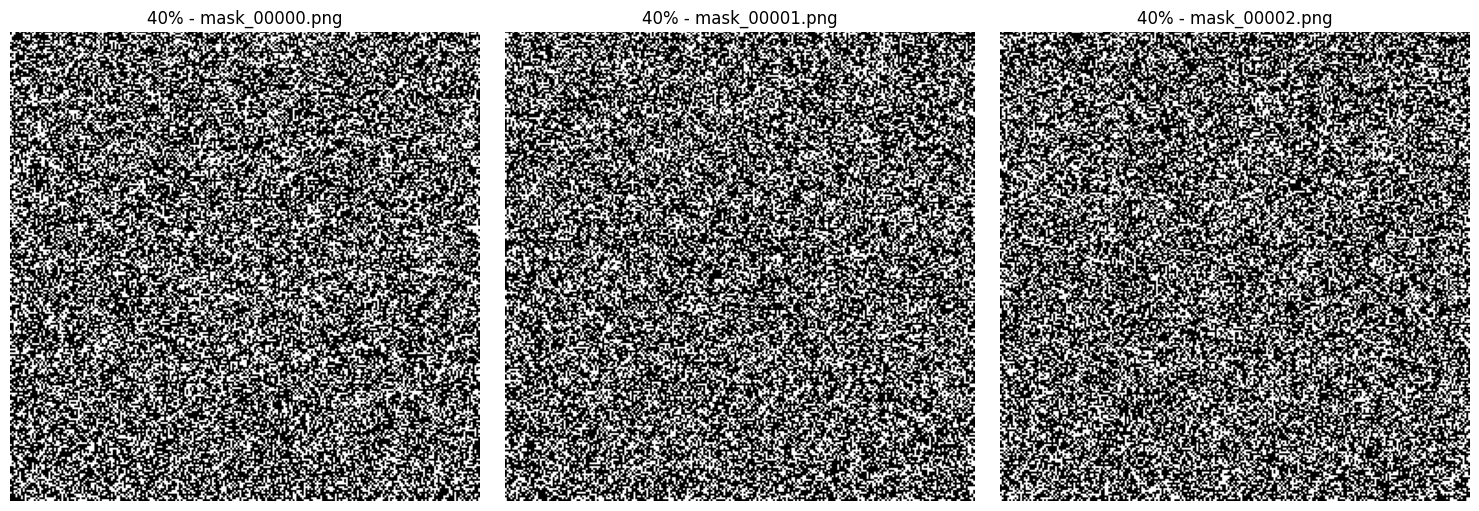

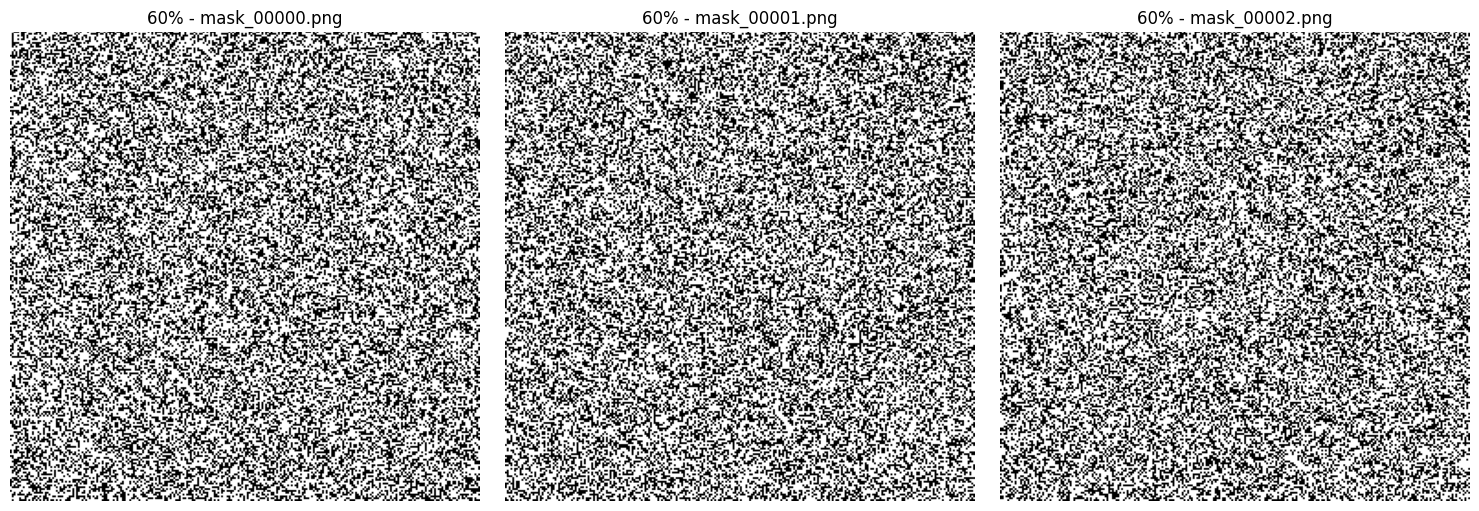

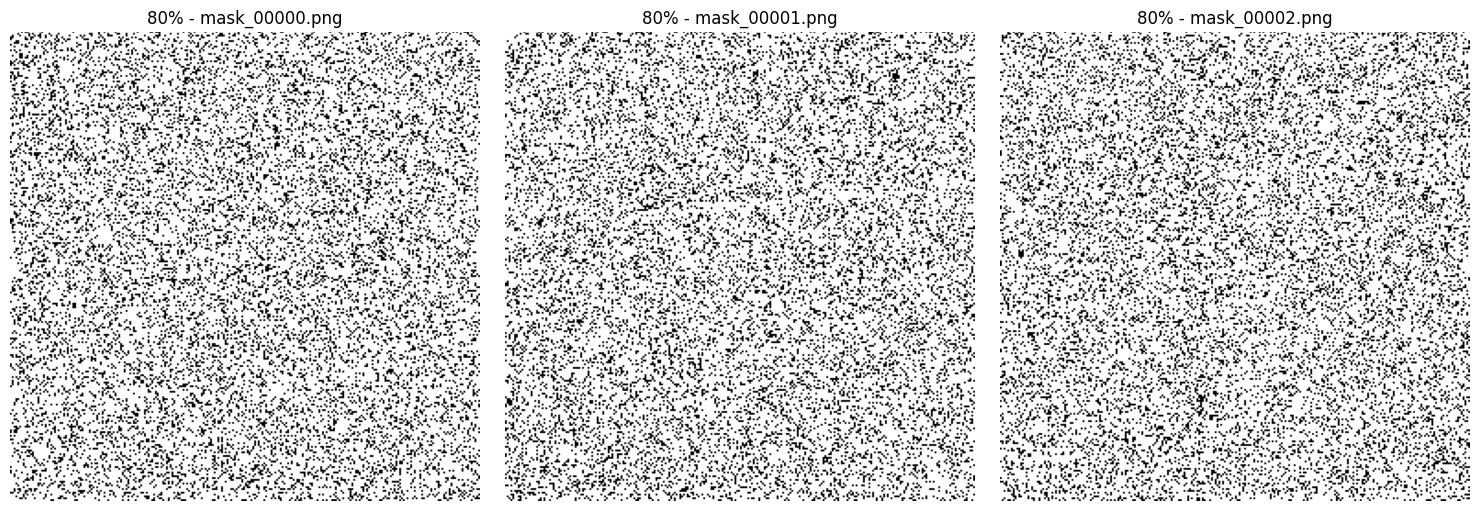

In [ ]:
def display_sample_masks(percent=20, num_samples=3):
    import matplotlib.pyplot as plt

    folder_path = f"/content/drive/MyDrive/masks_dataset/{percent}"
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found!")
        return

    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for i, filename in enumerate(files):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{percent}% - {filename}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display samples from each percentage
for percent in [20, 40, 60, 80]:
    display_sample_masks(percent, num_samples=3)

In [ ]:
!unzip /content/CelebAHQ_30kfaces.zip

In [ ]:
#!unzip /content/masks.zip

In [ ]:
# Must run all cells for path to 20% masks as well as 40/60/80% masks
import os

folder_path_faces = "/content/celeba_processed_128"
folder_path_masks = "/content/masks/40"

folder_output  = "/content/celeba_masked_faces/"
os.makedirs(folder_output, exist_ok=True)

''' Format of image file retrieval
file_celeb=folder_path_faces + "/" + sorted_celebfaces[0]

file_mask=folder_path_masks + "/" + sorted_masks20[0]
'''

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures # For parallel processing
from tqdm.notebook import tqdm # For progress bar


def get_sorted_files_pathlib(folder_path):
    """
    Get all file names using pathlib and sort them alphabetically.

    Args:
        folder_path (str): Path to the folder

    Returns:
        list: Sorted list of file names
    """
    try:
        folder = Path(folder_path)

        files = [file.name for file in folder.iterdir() if file.is_file()]

        files.sort()

        return files

    except FileNotFoundError:
        print(f"Error: Folder '{folder_path}' not found.")
        return []


def apply_mask_opencv(image_path, mask_path, output_path=None):
    """
    Apply a black and white mask to an image using OpenCV.

    Args:
        image_path: Path to the original image
        mask_path: Path to the black and white mask
        output_path: Optional path to save the result
    """
    # Read image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

    # Ensure mask is binary (0 and 255)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # INVERT THE MASK - swap black and white values
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Apply mask
    result = cv2.bitwise_and(image, image, mask=inverted_mask)

    # Convert BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    '''
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title('Binary Mask')
    axes[1].axis('off')

    axes[2].imshow(result_rgb)
    axes[2].set_title('Masked Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    '''
    # Save result if output path provided
    if output_path:
        cv2.imwrite(output_path, result)

    return result


sorted_celebfaces = get_sorted_files_pathlib(folder_path_faces)
sorted_masks20 = get_sorted_files_pathlib(folder_path_masks)

if len(sorted_celebfaces) != len(sorted_masks20):
  print("mismatch, # of celeb faces: ", len(sorted_celebfaces))
  print("# of masks: ", len(sorted_masks20))
else:
  # Prepare arguments for parallel processing
  tasks = []
  for i in range(len(sorted_celebfaces)):
    file_celeb = os.path.join(folder_path_faces, sorted_celebfaces[i])
    file_mask = os.path.join(folder_path_masks, sorted_masks20[i])
    output_filename = f'maskedface{i}.jpg' # Fixed string concatenation
    output_path = os.path.join(folder_output, output_filename)
    tasks.append((file_celeb, file_mask, output_path))

  # Define a helper function to unpack arguments for map
  def _apply_mask_wrapper(args):
      image_path, mask_path, output_path = args
      return apply_mask_opencv(image_path, mask_path, output_path)

  # Use ProcessPoolExecutor for parallel processing
  # Adjust max_workers based on available CPU cores. os.cpu_count() is a good default.
  num_cores = os.cpu_count() if os.cpu_count() else 1
  with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
      # Use tqdm for a progress bar
      for _ in tqdm(executor.map(_apply_mask_wrapper, tasks), total=len(tasks), desc="Applying masks"):
          pass # Just iterate to show progress
  print(f"Applied masks to {len(sorted_celebfaces)} images.")

Applying masks:   0%|          | 0/30000 [00:00<?, ?it/s]

Applied masks to 30000 images.


In [ ]:
import zipfile

def zip_images_folder(folder_path, zip_filename=None):
    """
    Zip all images in a folder.

    Args:
        folder_path: Path to folder containing images
        zip_filename: Name of output zip file (optional)
    """
    folder_path = Path(folder_path)

    if not folder_path.exists():
        raise ValueError(f"Folder does not exist: {folder_path}")

    # Set default zip filename if not provided
    if zip_filename is None:
        zip_filename = f"{folder_path.name}_images.zip"

    # Supported image extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

    # Find all image files
    image_files = [f for f in folder_path.iterdir()
                  if f.is_file() and f.suffix.lower() in image_extensions]

    if not image_files:
        print(f"No image files found in {folder_path}")
        return None

    # Create zip file
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for image_file in image_files:
            # Add file to zip, preserving directory structure
            zipf.write(image_file, image_file.name)
            print(f"Added: {image_file.name}")

    print(f"✅ Successfully created {zip_filename}")
    print(f"📦 Total files zipped: {len(image_files)}")
    print(f"💾 Zip file size: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

    return zip_filename

# Usage for your case
output_folder = "/content/celeba_masked_faces_upscaled_2x"
zip_file = zip_images_folder(output_folder)

No image files found in /content


## Preparing Environment

Import necessary libraries, define utility functions, and initialize the RePaintScheduler and RePaintPipeline with the google/ddpm-ema-celebahq-256 model, moving the pipeline to the GPU ('cuda').


In [ ]:
from sklearn.datasets import fetch_lfw_people
import PIL
import numpy as np
import os
import zipfile
from google.colab import files
from io import BytesIO
import torch
import requests
from diffusers import RePaintPipeline, RePaintScheduler
from PIL import Image, ImageOps
import time
from tqdm import tqdm


In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=14, resize=1, color=True)

print(len(lfw_people.target_names))

first_100_people = np.unique(lfw_people.target)[:100]

person_images = []

os.makedirs('/content/lfw_100_people', exist_ok=True)

for person_id in first_100_people:
    first_idx = np.where(lfw_people.target == person_id)[0][0]
    image_array = lfw_people.images[first_idx]
    person_name = lfw_people.target_names[person_id]

    img = Image.fromarray((image_array * 255).astype(np.uint8))

    img = img.resize((256, 256))

    # Clean filename (remove special characters)
    clean_name = "".join(c if c.isalnum() or c in (' ', '-', '_') else '_' for c in person_name)
    filename = f"{clean_name}_{person_id}.jpg"
    filepath = f"/content/lfw_100_people/{filename}"

    img.save(filepath)
    person_images.append((filename, person_name, person_id))

with zipfile.ZipFile('/content/lfw_100_people.zip', 'w') as zipf:
    for root, dirs, file_list_from_walk in os.walk('/content/lfw_100_people'):
        for file_name in file_list_from_walk:
            filepath = os.path.join(root, file_name)
            zipf.write(filepath, os.path.basename(filepath))

files.download('/content/lfw_100_people.zip')
print(f"Downloaded {len(person_images)} images with celebrities' name")

106


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded 100 images with celebrities' name


In [ ]:
zip_file_path = '/content/100masks80corruption.zip'
extraction_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"'{zip_file_path}' unzipped to '{extraction_path}'")

extracted_folder_name = '100masks80corruption'
full_path = os.path.join('/content/', extracted_folder_name)

print(f"Contents of '{full_path}':")
if os.path.exists(full_path) and os.path.isdir(full_path):
    for item in os.listdir(full_path):
        print(item)
else:
    print(f"Folder '{full_path}' not found.")


mask_folder = '/content/100masks80corruption'

if os.path.exists(mask_folder) and os.path.isdir(mask_folder):
    all_files = os.listdir(mask_folder)

    # Filter for mask files (assuming they end with .png)
    mask_files = [f for f in all_files if f.startswith('mask_') and f.endswith('.png')]

    # Sort the files numerically based on the number in the filename
    mask_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    if mask_files:
        print(f"First mask filename: {mask_files[0]}")
        print(f"Last mask filename: {mask_files[-1]}")
    else:
        print(f"No mask files found in {mask_folder}.")
else:
    print(f"Folder '{mask_folder}' not found or is not a directory.")

'/content/100masks80corruption.zip' unzipped to '/content/'
Contents of '/content/100masks80corruption':
mask_00036.png
mask_00045.png
mask_00060.png
mask_00026.png
mask_00077.png
mask_00009.png
mask_00061.png
mask_00017.png
mask_00085.png
mask_00096.png
mask_00037.png
mask_00054.png
mask_00022.png
mask_00062.png
mask_00063.png
mask_00013.png
mask_00010.png
mask_00023.png
mask_00031.png
mask_00050.png
mask_00099.png
mask_00004.png
mask_00029.png
mask_00095.png
mask_00018.png
mask_00078.png
mask_00046.png
mask_00093.png
mask_00039.png
mask_00027.png
mask_00067.png
mask_00008.png
mask_00072.png
mask_00028.png
mask_00035.png
mask_00069.png
mask_00043.png
mask_00094.png
mask_00057.png
mask_00042.png
mask_00038.png
mask_00065.png
mask_00082.png
mask_00092.png
mask_00015.png
mask_00000.png
mask_00081.png
mask_00089.png
mask_00049.png
mask_00033.png
mask_00068.png
mask_00006.png
mask_00073.png
mask_00034.png
mask_00080.png
mask_00075.png
mask_00084.png
mask_00012.png
mask_00019.png
mask_00055

In [ ]:
scheduler = RePaintScheduler.from_pretrained("google/ddpm-ema-celebahq-256")

pipe = RePaintPipeline.from_pretrained("google/ddpm-ema-celebahq-256", scheduler=scheduler)

pipe = pipe.to("cuda")

print("RePaintScheduler and RePaintPipeline initialized and moved to GPU.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-ema-celebahq-256/snapshots/4cb6117472e6e4f45c5afe606b101858c27c3802: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-ema-celebahq-256/snapshots/4cb6117472e6e4f45c5afe606b101858c27c3802.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


RePaintScheduler and RePaintPipeline initialized and moved to GPU.


In [ ]:
'''
scheduler = RePaintScheduler.from_pretrained("google/ddpm-ema-celebahq-256")

pipe = RePaintPipeline.from_pretrained("google/ddpm-ema-celebahq-256", scheduler=scheduler)

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

print(f"RePaintScheduler and RePaintPipeline initialized and moved to {device}.")
'''

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-ema-celebahq-256/snapshots/4cb6117472e6e4f45c5afe606b101858c27c3802: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-ema-celebahq-256/snapshots/4cb6117472e6e4f45c5afe606b101858c27c3802.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


RePaintScheduler and RePaintPipeline initialized and moved to cpu.


In [ ]:
def load_and_preprocess_image_mask(image_path, mask_path, target_size=(256, 256)):
    """
    Loads an image and a mask, resizes them to target_size, and inverts the mask.

    Args:
        image_path (str): Path to the original image.
        mask_path (str): Path to the mask image.
        target_size (tuple): Desired (width, height) for resizing.

    Returns:
        tuple: A tuple containing the resized original image (PIL.Image) and
               the resized, inverted mask image (PIL.Image).
    """
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

    image = image.resize(target_size)
    mask = mask.resize(target_size)

    # Invert the mask (white pixels become black, black become white)
    # The RePaint pipeline expects the mask to be 'inverted' relative to how it's typically generated
    # where white areas are to be inpainted and black areas are kept.
    mask = ImageOps.invert(mask)

    # The mask should remain a single channel (grayscale) for the RePaint scheduler,
    # which will broadcast it across the image's RGB channels.
    # No need to convert to RGB here.

    return image, mask

print("Utility function 'load_and_preprocess_image_mask' defined (corrected).")

Utility function 'load_and_preprocess_image_mask' defined (corrected).


## Get Image and Mask Paths and Create Output Folder

### Subtask:
Retrieve and sort the file paths for the images and mask files to ensure consistent processing order, then create the output directory for inpainted images.


In [ ]:
image_folder_path = '/content/lfw_100_people'
mask_folder_path = '/content/100masks80corruption'
output_folder_path = '/content/inpainted_mask80'

# Create the output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)
print(f"Output folder created at: {output_folder_path}")

# Get sorted lists of image and mask filenames
image_filenames = sorted(os.listdir(image_folder_path))
mask_filenames = sorted(os.listdir(mask_folder_path))

print(f"Found {len(image_filenames)} image files in '{image_folder_path}'.")
print(f"Found {len(mask_filenames)} mask files in '{mask_folder_path}'.")
print(f"First image file: {image_filenames[0]}")
print(f"First mask file: {mask_filenames[0]}")

Output folder created at: /content/inpainted_mask80
Found 100 image files in '/content/lfw_100_people'.
Found 100 mask files in '/content/100masks80corruption'.
First image file: Abdullah Gul_0.jpg
First mask file: mask_00000.png


## Inpaint


In [ ]:
output_folder_path = '/content/inpainted_mask80_50to69'
os.makedirs(output_folder_path, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device).manual_seed(0)

inpainting_durations = []

num_files_to_process = min(len(image_filenames), len(mask_filenames))

for i in range(50,70):
    current_image_filename = image_filenames[i]
    current_mask_filename = mask_filenames[i]

    image_full_path = os.path.join(image_folder_path, current_image_filename)
    mask_full_path = os.path.join(mask_folder_path, current_mask_filename)

    # Load and preprocess image and mask
    original_image, inverted_mask = load_and_preprocess_image_mask(
        image_full_path, mask_full_path
    )

    # Record start time
    start_time = time.time()

    # Perform inpainting
    output = pipe(
        image=original_image,
        mask_image=inverted_mask,
        num_inference_steps=250,
        eta=0.0,
        jump_length=10,
        jump_n_sample=10,
        generator=generator,
    )

    # Record end time and calculate duration
    end_time = time.time()
    duration = end_time - start_time
    inpainting_durations.append(duration)

    # Extract and save inpainted image
    inpainted_image = output.images[0]

    # Construct output filename
    base_name = os.path.splitext(current_image_filename)[0]
    output_filename = f"{base_name}_inpainted.png"
    output_file_path = os.path.join(output_folder_path, output_filename)

    inpainted_image.save(output_file_path)

    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{num_files_to_process} images. Last image saved to {output_file_path}")

print(f"\nFinished inpainting {num_files_to_process} images.")

# Print statistics about inpainting durations
if inpainting_durations:
    print("\nInpainting Duration Statistics:")
    print(f"  Total images inpainted: {len(inpainting_durations)}")
    print(f"  Average duration per image: {np.mean(inpainting_durations):.2f} seconds")
    print(f"  Minimum duration per image: {np.min(inpainting_durations):.2f} seconds")
    print(f"  Maximum duration per image: {np.max(inpainting_durations):.2f} seconds")
else:
    print("No inpainting was performed.")

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/deprecated/repaint/pipeline_repaint.py:35: FutureWarning: The preprocess method is deprecated and will be removed in diffusers 1.0.0. Please use VaeImageProcessor.preprocess(...) instead
  deprecate("preprocess", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

Processed 60/100 images. Last image saved to /content/inpainted_mask80_50to69/Kim Clijsters_59_inpainted.png


  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

Processed 70/100 images. Last image saved to /content/inpainted_mask80_50to69/Meryl Streep_69_inpainted.png

Finished inpainting 100 images.

Inpainting Duration Statistics:
  Total images inpainted: 20
  Average duration per image: 341.62 seconds
  Minimum duration per image: 339.73 seconds
  Maximum duration per image: 341.90 seconds


In [ ]:

zip_filename = 'inpainted_mask80_50to69.zip'
zip_file_path = os.path.join('/content/', zip_filename)

with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files_in_dir in os.walk(output_folder_path):
        for file_name in files_in_dir:
            filepath = os.path.join(root, file_name)
            zipf.write(filepath, os.path.relpath(filepath, output_folder_path))

files.download(zip_file_path)
print(f"'{zip_filename}' has been created and downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'inpainted_mask80_50to69.zip' has been created and downloaded.


In [ ]:
zip_file_path = '/content/100masks60corruption.zip'
extraction_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"'{zip_file_path}' unzipped to '{extraction_path}'")

extracted_folder_name = '100masks60corruption'
full_path = os.path.join('/content/', extracted_folder_name)

print(f"Contents of '{full_path}':")
if os.path.exists(full_path) and os.path.isdir(full_path):
    for item in os.listdir(full_path):
        print(item)
else:
    print(f"Folder '{full_path}' not found.")


mask_folder = '/content/100masks60corruption'

if os.path.exists(mask_folder) and os.path.isdir(mask_folder):
    all_files = os.listdir(mask_folder)

    # Filter for mask files (assuming they end with .png)
    mask_files = [f for f in all_files if f.startswith('mask_') and f.endswith('.png')]

    # Sort the files numerically based on the number in the filename
    mask_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    if mask_files:
        print(f"First mask filename: {mask_files[0]}")
        print(f"Last mask filename: {mask_files[-1]}")
    else:
        print(f"No mask files found in {mask_folder}.")
else:
    print(f"Folder '{mask_folder}' not found or is not a directory.")

'/content/100masks60corruption.zip' unzipped to '/content/'
Contents of '/content/100masks60corruption':
mask_89.png
mask_24.png
mask_47.png
mask_53.png
mask_8.png
mask_0.png
mask_82.png
mask_31.png
mask_4.png
mask_96.png
mask_94.png
mask_40.png
mask_69.png
mask_85.png
mask_32.png
mask_79.png
mask_45.png
mask_21.png
mask_99.png
mask_90.png
mask_61.png
mask_5.png
mask_44.png
mask_36.png
mask_16.png
mask_80.png
mask_13.png
mask_97.png
mask_95.png
mask_68.png
mask_81.png
mask_63.png
mask_14.png
mask_26.png
mask_7.png
mask_10.png
mask_76.png
mask_60.png
mask_54.png
mask_98.png
mask_86.png
mask_25.png
mask_23.png
mask_38.png
mask_22.png
mask_15.png
mask_83.png
mask_2.png
mask_33.png
mask_17.png
mask_34.png
mask_28.png
mask_51.png
mask_39.png
mask_78.png
mask_29.png
mask_20.png
mask_84.png
mask_75.png
mask_56.png
mask_9.png
mask_27.png
mask_46.png
mask_77.png
mask_64.png
mask_57.png
mask_74.png
mask_18.png
mask_62.png
mask_67.png
mask_65.png
mask_91.png
mask_93.png
mask_72.png
mask_70.png
ma

In [ ]:
image_folder_path = '/content/lfw_100_people'
mask_folder_path = '/content/100masks60corruption'
output_folder_path = '/content/inpainted_mask60'

# Create the output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)
print(f"Output folder created at: {output_folder_path}")

# Get sorted lists of image and mask filenames
image_filenames = sorted(os.listdir(image_folder_path))
mask_filenames = sorted(os.listdir(mask_folder_path))

print(f"Found {len(image_filenames)} image files in '{image_folder_path}'.")
print(f"Found {len(mask_filenames)} mask files in '{mask_folder_path}'.")
print(f"First image file: {image_filenames[0]}")
print(f"First mask file: {mask_filenames[0]}")

Output folder created at: /content/inpainted_mask60
Found 100 image files in '/content/lfw_100_people'.
Found 100 mask files in '/content/100masks60corruption'.
First image file: Abdullah Gul_0.jpg
First mask file: mask_0.png


In [ ]:
output_folder_path = '/content/inpainted_mask60_70to80'
os.makedirs(output_folder_path, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device).manual_seed(0)

inpainting_durations = []
num_files_to_process = min(len(image_filenames), len(mask_filenames))

for i in range(70,80):
    current_image_filename = image_filenames[i]
    current_mask_filename = mask_filenames[i]

    image_full_path = os.path.join(image_folder_path, current_image_filename)
    mask_full_path = os.path.join(mask_folder_path, current_mask_filename)

    # Load and preprocess image and mask
    original_image, inverted_mask = load_and_preprocess_image_mask(
        image_full_path, mask_full_path
    )

    # Record start time
    start_time = time.time()

    # Perform inpainting
    output = pipe(
        image=original_image,
        mask_image=inverted_mask,
        num_inference_steps=250,
        eta=0.0,
        jump_length=10,
        jump_n_sample=10,
        generator=generator,
    )

    # Record end time and calculate duration
    end_time = time.time()
    duration = end_time - start_time
    inpainting_durations.append(duration)

    # Extract and save inpainted image
    inpainted_image = output.images[0]

    # Construct output filename
    base_name = os.path.splitext(current_image_filename)[0]
    output_filename = f"{base_name}_inpainted.png"
    output_file_path = os.path.join(output_folder_path, output_filename)

    inpainted_image.save(output_file_path)

    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{num_files_to_process} images. Last image saved to {output_file_path}")

print(f"\nFinished inpainting {num_files_to_process} images.")

# Print statistics about inpainting durations
if inpainting_durations:
    print("\nInpainting Duration Statistics:")
    print(f"  Total images inpainted: {len(inpainting_durations)}")
    print(f"  Average duration per image: {np.mean(inpainting_durations):.2f} seconds")
    print(f"  Minimum duration per image: {np.min(inpainting_durations):.2f} seconds")
    print(f"  Maximum duration per image: {np.max(inpainting_durations):.2f} seconds")
else:
    print("No inpainting was performed.")

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

Processed 80/100 images. Last image saved to /content/inpainted_mask60_70to80/Pervez Musharraf_79_inpainted.png

Finished inpainting 100 images.

Inpainting Duration Statistics:
  Total images inpainted: 10
  Average duration per image: 341.84 seconds
  Minimum duration per image: 341.60 seconds
  Maximum duration per image: 342.09 seconds


In [ ]:
zip_filename = 'inpainted_mask60_70to80.zip'
zip_file_path = os.path.join('/content/', zip_filename)

with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files_in_dir in os.walk(output_folder_path):
        for file_name in files_in_dir:
            filepath = os.path.join(root, file_name)
            zipf.write(filepath, os.path.relpath(filepath, output_folder_path))

files.download(zip_file_path)
print(f"'{zip_filename}' has been created and downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'inpainted_mask60_70to80.zip' has been created and downloaded.


In [ ]:
output_folder_path = '/content/inpainted_mask80_80to99'
os.makedirs(output_folder_path, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device).manual_seed(0)

inpainting_durations = []
num_files_to_process = min(len(image_filenames), len(mask_filenames))

for i in range(80,100):
    current_image_filename = image_filenames[i]
    current_mask_filename = mask_filenames[i]

    image_full_path = os.path.join(image_folder_path, current_image_filename)
    mask_full_path = os.path.join(mask_folder_path, current_mask_filename)

    # Load and preprocess image and mask
    original_image, inverted_mask = load_and_preprocess_image_mask(
        image_full_path, mask_full_path
    )

    # Record start time
    start_time = time.time()

    # Perform inpainting
    output = pipe(
        image=original_image,
        mask_image=inverted_mask,
        num_inference_steps=250,
        eta=0.0,
        jump_length=10,
        jump_n_sample=10,
        generator=generator,
    )

    # Record end time and calculate duration
    end_time = time.time()
    duration = end_time - start_time
    inpainting_durations.append(duration)

    # Extract and save inpainted image
    inpainted_image = output.images[0]

    # Construct output filename
    base_name = os.path.splitext(current_image_filename)[0]
    output_filename = f"{base_name}_inpainted.png"
    output_file_path = os.path.join(output_folder_path, output_filename)

    inpainted_image.save(output_file_path)

    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{num_files_to_process} images. Last image saved to {output_file_path}")

print(f"\nFinished inpainting {num_files_to_process} images.")

# Print statistics about inpainting durations
if inpainting_durations:
    print("\nInpainting Duration Statistics:")
    print(f"  Total images inpainted: {len(inpainting_durations)}")
    print(f"  Average duration per image: {np.mean(inpainting_durations):.2f} seconds")
    print(f"  Minimum duration per image: {np.min(inpainting_durations):.2f} seconds")
    print(f"  Maximum duration per image: {np.max(inpainting_durations):.2f} seconds")
else:
    print("No inpainting was performed.")

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/deprecated/repaint/pipeline_repaint.py:35: FutureWarning: The preprocess method is deprecated and will be removed in diffusers 1.0.0. Please use VaeImageProcessor.preprocess(...) instead
  deprecate("preprocess", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

Processed 90/100 images. Last image saved to /content/inpainted_mask80_80to99retest/Saddam Hussein_89_inpainted.png


  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

Processed 100/100 images. Last image saved to /content/inpainted_mask80_80to99retest/Tony Blair_99_inpainted.png

Finished inpainting 100 images.

Inpainting Duration Statistics:
  Total images inpainted: 20
  Average duration per image: 341.28 seconds
  Minimum duration per image: 341.12 seconds
  Maximum duration per image: 341.73 seconds


In [ ]:
zip_filename = 'inpainted_mask80_80to99.zip'
zip_file_path = os.path.join('/content/', zip_filename)

with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files_in_dir in os.walk(output_folder_path):
        for file_name in files_in_dir:
            filepath = os.path.join(root, file_name)
            zipf.write(filepath, os.path.relpath(filepath, output_folder_path))

files.download(zip_file_path)
print(f"'{zip_filename}' has been created and downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'inpainted_mask80_80to99retest.zip' has been created and downloaded.
